In [1]:
import time
import os
import pickle
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt


import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
# Check if a GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set memory growth for GPU (if needed)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


#### Check what sort of data do we have in train and test txt files. 

Each split has name of class and filename of image

In [5]:
!tail '/kaggle/input/food-101/food-101/food-101/meta/train.txt'

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


waffles/961486
waffles/97524
waffles/97567
waffles/978448
waffles/98131
waffles/981485
waffles/98238
waffles/982668
waffles/995085
waffles/999047


# Read Data and perform required data normalizations

In [6]:
df_train = pd.read_csv('/kaggle/input/food-101/food-101/food-101/meta/train.txt', header = None, names=['path'])
df_test = pd.read_csv('/kaggle/input/food-101/food-101/food-101/meta/test.txt', header = None, names=['path'])

In [7]:
df_train.head()

,path
0,apple_pie/1005649
1,apple_pie/1014775
2,apple_pie/1026328
3,apple_pie/1028787
4,apple_pie/1043283


### Create columns containing the class name or label

Get labels from the directory names in the 'path' (eg apple_pie)

In [8]:
df_train['label'] = df_train['path'].map(lambda path_str: path_str.split('/')[0]) 
df_test['label'] = df_test['path'].map(lambda path_str: path_str.split('/')[0]) 



In [9]:
df_train.tail()

,path,label
75745,waffles/981485,waffles
75746,waffles/98238,waffles
75747,waffles/982668,waffles
75748,waffles/995085,waffles
75749,waffles/999047,waffles


In [10]:
df_train["path"] = df_train["path"].map(lambda path_str: '/kaggle/input/food-101/food-101/food-101/images/'+path_str+'.jpg')
df_test["path"] = df_test["path"].map(lambda path_str: '/kaggle/input/food-101/food-101/food-101/images/'+path_str+'.jpg')
df_train.head()

,path,label
0,/kaggle/input/food-101/food-101/food-101/image...,apple_pie
1,/kaggle/input/food-101/food-101/food-101/image...,apple_pie
2,/kaggle/input/food-101/food-101/food-101/image...,apple_pie
3,/kaggle/input/food-101/food-101/food-101/image...,apple_pie
4,/kaggle/input/food-101/food-101/food-101/image...,apple_pie


### Filter dataset. Create subset for the 21 classes

In [11]:
food_labels = [
    "apple_pie",
    "baby_back_ribs",
    "baklava",
    "beef_carpaccio",
    "beef_tartare",
    "beet_salad",
    "beignets",
    "bibimbap",
    "bread_pudding",
    "breakfast_burrito",
    "bruschetta",
    "caesar_salad",
    "cannoli",
    "caprese_salad",
    "carrot_cake",
    "ceviche",
    "cheesecake",
    "cheese_plate",
    "chicken_curry",
    "chicken_quesadilla"
]

def class_label(label_str):
    if label_str in food_labels:
        return label_str
    else:
        return "other"
        

df_train['label'] = df_train['label'].map(lambda x: class_label(x))
df_test['label'] = df_test['label'].map(lambda x: class_label(x))

In [12]:
df_train["label"].value_counts()

label
other                 60750
baby_back_ribs          750
baklava                 750
beef_carpaccio          750
apple_pie               750
beef_tartare            750
beet_salad              750
bibimbap                750
beignets                750
breakfast_burrito       750
bruschetta              750
caesar_salad            750
bread_pudding           750
cannoli                 750
caprese_salad           750
ceviche                 750
carrot_cake             750
cheesecake              750
cheese_plate            750
chicken_curry           750
chicken_quesadilla      750
Name: count, dtype: int64

In [13]:
df_test["label"].value_counts()

label
other                 20250
baby_back_ribs          250
baklava                 250
beef_carpaccio          250
apple_pie               250
beef_tartare            250
beet_salad              250
bibimbap                250
beignets                250
breakfast_burrito       250
bruschetta              250
caesar_salad            250
bread_pudding           250
cannoli                 250
caprese_salad           250
ceviche                 250
carrot_cake             250
cheesecake              250
cheese_plate            250
chicken_curry           250
chicken_quesadilla      250
Name: count, dtype: int64

In [14]:
df_train.head()

,path,label
0,/kaggle/input/food-101/food-101/food-101/image...,apple_pie
1,/kaggle/input/food-101/food-101/food-101/image...,apple_pie
2,/kaggle/input/food-101/food-101/food-101/image...,apple_pie
3,/kaggle/input/food-101/food-101/food-101/image...,apple_pie
4,/kaggle/input/food-101/food-101/food-101/image...,apple_pie


# Model Preparation

In [ ]:
def get_data_generators(train_data, test_data):
    # Augment Images so that model can different variations in the images. It will help the model to learn diverse cases
    train_augment = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_augment = ImageDataGenerator(rescale=1./255)


    # Create data generators. We will use them later to read the train or test dataset images. 

    train_gentr = train_augment.flow_from_dataframe(dataframe = train_data, x_col='path', y_col='label',
        target_size=(256, 256), batch_size=16, shuffle=True)
    test_gentr = test_augment.flow_from_dataframe(dataframe = test_data, x_col='path', y_col='label',
        target_size=(256, 256), batch_size=16, shuffle=True)
    
    return train_gentr,test_gentr


def create_model():
    # Load pre-trained model. InceptionV3 in our case
    pre_trained = Xception(weights='imagenet', include_top=False)

    x = pre_trained.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256,activation='relu')(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.1)(x)
    predictions = Dense(21, activation='softmax')(x)

    model = Model(inputs=pre_trained.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def save_model(model_obj, hist_obj):
    model_file_path = "/kaggle/working/food101_tunned_x.h5"
    history_file_path = '/kaggle/working/history_tunned_x.pkl'
    model_obj.save(model_file_path) 

    with open(history_file_path, 'wb') as file:
        pickle.dump(hist_obj.history, file)

In [15]:
# Get the image data generators for train and test
train_gentr,test_gentr = get_data_generators(df_train, df_test)

Found 75750 validated image filenames belonging to 21 classes.
Found 25250 validated image filenames belonging to 21 classes.


In [16]:
# Create model object to train

model = create_model()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [17]:
# Train the model

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

t1 = time.time()

# Train the model
history = model.fit(
    train_gentr,
    epochs=80,
    steps_per_epoch = len(train_gentr) // 16,
    callbacks=[early_stopping],
    validation_data=test_gentr
)
train_time = time.time()-t1

print("Training time: ", train_time)

Epoch 1/80


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729938557.003998     104 service.cc:145] XLA service 0x7ed4d4001740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729938557.004067     104 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729938580.769752     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_2', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1729938580.805615     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most

295/295 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.7586 - loss: 1.4142 - val_accuracy: 0.8020 - val_loss: 0.9320
Epoch 2/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 177s 601ms/step - accuracy: 0.7921 - loss: 0.9719 - val_accuracy: 0.8254 - val_loss: 0.6844
Epoch 3/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 173s 587ms/step - accuracy: 0.8106 - loss: 0.7878 - val_accuracy: 0.8456 - val_loss: 0.5580
Epoch 4/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 174s 591ms/step - accuracy: 0.8319 - loss: 0.6197 - val_accuracy: 0.8533 - val_loss: 0.5217
Epoch 5/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 174s 591ms/step - accuracy: 0.8437 - loss: 0.5705 - val_accuracy: 0.8694 - val_loss: 0.4621
Epoch 6/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 167s 568ms/step - accuracy: 0.8511 - loss: 0.5363 - val_accuracy: 0.8709 - val_loss: 0.4503
Epoch 7/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 160s 545ms/step - accuracy: 0.8565 - loss: 0.5380 - val_accuracy: 0.8669 - val_loss: 0.4604
Epoch 8/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 144s 491ms/step - accuracy: 0.8753 - loss: 0.4427 

I0000 00:00:1729941066.238508     107 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 480 bytes spill stores, 480 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 68 bytes spill stores, 68 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 80 bytes spill stores, 80 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 68 bytes spill stores, 68 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_124', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_122', 12 bytes spill stores, 12 bytes spill loads



295/295 ━━━━━━━━━━━━━━━━━━━━ 142s 483ms/step - accuracy: 0.8906 - loss: 0.3992 - val_accuracy: 0.8988 - val_loss: 0.3701
Epoch 17/80
 15/295 ━━━━━━━━━━━━━━━━━━━━ 47s 168ms/step - accuracy: 0.9068 - loss: 0.3335

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


295/295 ━━━━━━━━━━━━━━━━━━━━ 75s 256ms/step - accuracy: 0.9083 - loss: 0.3158 - val_accuracy: 0.8979 - val_loss: 0.3700
Epoch 18/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 172s 577ms/step - accuracy: 0.9022 - loss: 0.3513 - val_accuracy: 0.8888 - val_loss: 0.3889
Epoch 19/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 172s 583ms/step - accuracy: 0.8934 - loss: 0.3806 - val_accuracy: 0.8982 - val_loss: 0.3547
Epoch 20/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 168s 570ms/step - accuracy: 0.9067 - loss: 0.3270 - val_accuracy: 0.8999 - val_loss: 0.3478
Epoch 21/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 168s 569ms/step - accuracy: 0.9060 - loss: 0.3457 - val_accuracy: 0.8985 - val_loss: 0.3495
Epoch 22/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 166s 564ms/step - accuracy: 0.9136 - loss: 0.3123 - val_accuracy: 0.8969 - val_loss: 0.3768
Epoch 23/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 168s 569ms/step - accuracy: 0.9163 - loss: 0.2987 - val_accuracy: 0.9027 - val_loss: 0.3555
Epoch 24/80
295/295 ━━━━━━━━━━━━━━━━━━━━ 166s 564ms/step - accuracy: 0.9064 - loss

In [21]:
save_model(model, history)

In [23]:
test_loss, test_accuracy = model.evaluate(test_gentr, batch_size=16)
test_accuracy = round(test_accuracy*100, 0)
print(f'Test Accuracy: {test_accuracy: .2f}')
print(f'Test Loss: {test_loss: .3f}')

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 98s 62ms/step - accuracy: 0.9063 - loss: 0.3426
Test Accuracy:  91.00
Test Loss:  0.328


#### Training accuray and loss plot

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

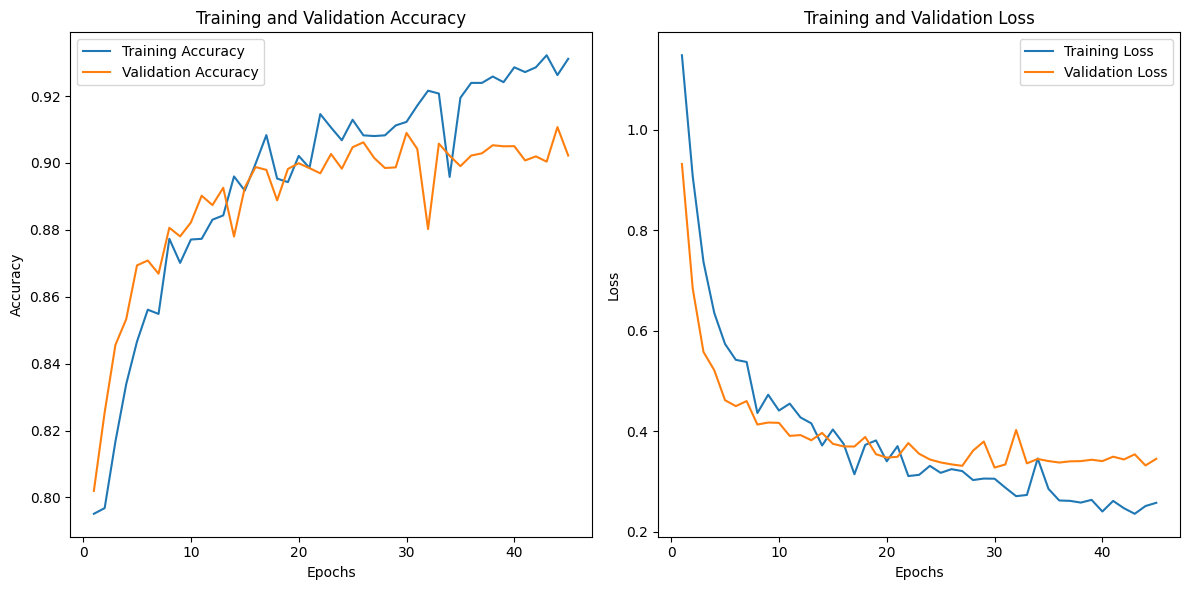

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

with open('/kaggle/working/history_tunned_x.pkl', 'rb') as file:
    loaded_history = pickle.load(file)


history_dict = loaded_history
epochs = range(1, len(history_dict['accuracy']) + 1)

# Step 2: Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
sns.lineplot(x=epochs, y=history_dict['accuracy'], label='Training Accuracy')
sns.lineplot(x=epochs, y=history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
sns.lineplot(x=epochs, y=history_dict['loss'], label='Training Loss')
sns.lineplot(x=epochs, y=history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()
